In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [0]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)



In [3]:
'''Trains a simple convnet on the MNIST dataset.


'''



Running TensorFlow version  1.15.2


In [2]:
# Switch to Tensorflow version 1 if you want to run the sections of code that have yet to be converted to Tensorflow 2
#%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Version 1, minor 15


In [0]:
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Functional API
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [0]:
import os
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

import IPython

# Utility routines

In [0]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

def prepareData(X_train, y_train, X_test, y_test, flatten=True):
  if tf.keras.backend.image_data_format() == 'channels_first':
      X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
      X_test  = X_test.reshape( X_test.shape[0], 1, img_rows, img_cols)
      input_shape = (1, img_rows, img_cols)
  else:
      X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
      X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)

  return input_shape, X_train, y_train, X_test, y_test


In [0]:
def showImage(img, ax=plt, cmap=None):
  # Some datasets (e.g., MNIST) have only 1 channel instead of 3
  if img.shape[-1] == 1:
    img = img[:,:, 0]
    cmap = "gray"
  
  
  if cmap is None:
    _= ax.imshow(img)
  else:
    _= ax.imshow(img, cmap=cmap)
    
   
def showTrain(xtrain, ytrain, num=5):
  #  ytrain is OHE
  num_classes = ytrain.shape[-1]

  fig = plt.figure(figsize=(12,12))
  for thisClass in range(0, num_classes):
    xtrain_thisClass = xtrain[ ytrain[:,thisClass] == 1]

    for i in range(0,num):
      ax = fig.add_subplot(num_classes, num, thisClass * num + i +1)
      showImage(xtrain_thisClass[i], ax)

      # ax.set_title(y[i])
      # ax.set_xlabel( idxs[i] )
      ax.set_xticks([])
      ax.set_yticks([])


def trainModel(model, modelName, X_train, y_train, X_test, y_test, batch_size = 128, epochs=20, num_classes=10):
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
              ]   

  model.compile(loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy']
                )

  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)
  

  model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks,
            validation_data=(X_test, y_test)
            )
  
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  return score[1], plotFile

# Get the data, prepare it

In [0]:

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) =  fashion_mnist.load_data()

input_shape, X_train, y_train, X_test, y_test = prepareData(X_train, y_train, X_test, y_test)


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

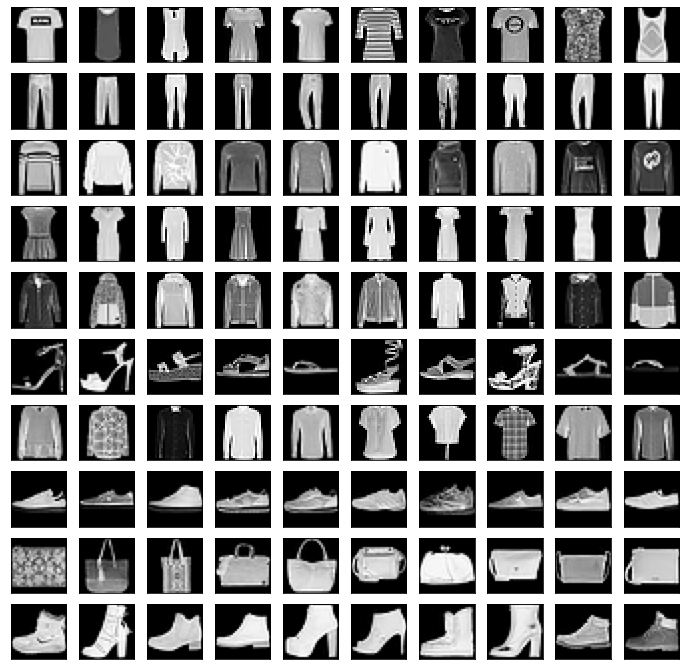

In [10]:
showTrain(X_train, y_train, num=10)

# Routines to create models

In [0]:
def createModelClassifier(input_shape, num_classes=10):
  model = Sequential( [ Flatten(input_shape=input_shape),
                        Dense(num_classes, activation='softmax') 
                        ]
                     )
  return model

def createModel1():
  model = Sequential( [ 
                       Conv2D(32, kernel_size=(3, 3),
                              activation='relu',
                              input_shape=input_shape),
                       Flatten(),
                       Dense(128, activation='relu'),
                       Dropout(0.5),
                       Dense(num_classes, activation='softmax')
  ]
)

  return model

In [0]:
def createModel(input_shape, num_filters=[32], num_classes=10, pool=[], extraDense=False):
  # Create first layer: needs input_spec
  model = Sequential( [ 
                        Conv2D(num_filters[0], kernel_size=(3, 3),
                                activation='relu',
                              input_shape=input_shape) 
                        ]
                    )
  
  # Add more Conv/Pooling layers
  for i in range(1, len(num_filters)):   
    if  (len(pool) > i) and pool[i]:
      print("Adding Pool + Conv block with {n:d} filters".format(n=num_filters[i]))
      model.add( MaxPooling2D(pool_size=(2, 2)) )
    else:
      print("Adding Conv block with {n:d} filters".format(n=num_filters[i]))

    model.add( Conv2D(num_filters[i], (3, 3), activation='relu'))
    model.add( Dropout(0.25))

  # Add tail
  model.add( Flatten() )

  if extraDense:
    model.add( Dense(128, activation='relu') )
    model.add( Dropout(0.5) )

  model.add( Dense(num_classes, activation='softmax') )

  return model
             

# Model: simple classifier (no convolution)

In [13]:
mnist_classifier_model = createModelClassifier(input_shape, num_classes=num_classes)
modelName="mnist_classifier"

acc, plotFile = trainModel(mnist_classifier_model, modelName, X_train, y_train, X_test, y_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 30us/sample - loss: 22.7247 - acc: 0.6962 - val_loss: 12.7930 - val_acc: 0.7753
Epoch 2/20
60000/60000 [==============================] - 1s 22us/sample - loss: 15.3516 - acc: 0.7663 - val_loss: 12.3890 - val_acc: 0.7743
Epoch 3/20
60000/60000 [==============================] - 1s 22us/sample - loss: 14.0966 - acc: 0.7774 - val_loss: 18.7829 - val_acc: 0.7026
Epoch 4/20
60000/60000 [==============================] - 1s 22us/sample - loss: 13.5937 - acc: 0.7828 - val_loss: 29.0078 - val_acc: 0.6939
Test loss: 12.38904930381775
Test accuracy: 0.7743


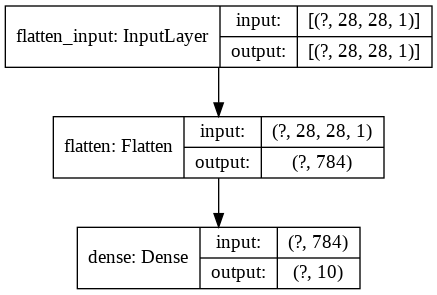

In [14]:
IPython.display.Image( plotFile) 

# Model: One Convolutional Layer (32 fileters)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 67us/sample - loss: 4.3233 - acc: 0.8261 - val_loss: 0.3977 - val_acc: 0.8668
Epoch 2/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.3187 - acc: 0.8895 - val_loss: 0.3816 - val_acc: 0.8766
Epoch 3/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.2781 - acc: 0.9017 - val_loss: 0.3921 - val_acc: 0.8787
Epoch 4/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.2584 - acc: 0.9097 - val_loss: 0.3916 - val_acc: 0.8773
Test loss: 0.3815714174628258
Test accuracy: 0.8766


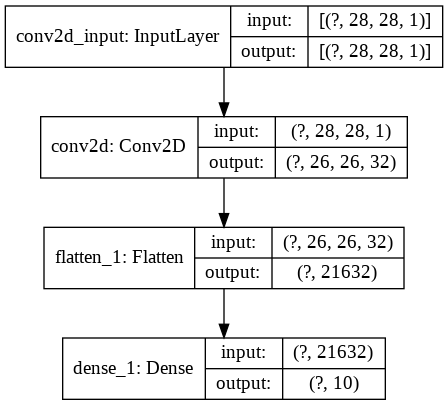

In [15]:
mnist_conv1_model = createModel(input_shape, num_filters=[32], num_classes=num_classes)
modelName="mnist_conv1"

acc, plotFile = trainModel(mnist_conv1_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 

# Model: 2 Convolutional Layers (32, 64 filters)

Adding Conv block with 64 filters
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 82us/sample - loss: 1.6844 - acc: 0.8350 - val_loss: 0.3736 - val_acc: 0.8714
Epoch 2/20
60000/60000 [==============================] - 4s 74us/sample - loss: 0.3333 - acc: 0.8848 - val_loss: 0.3794 - val_acc: 0.8735
Epoch 3/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.3001 - acc: 0.8947 - val_loss: 0.3710 - val_acc: 0.8731
Test loss: 0.3735503230333328
Test accuracy: 0.8714


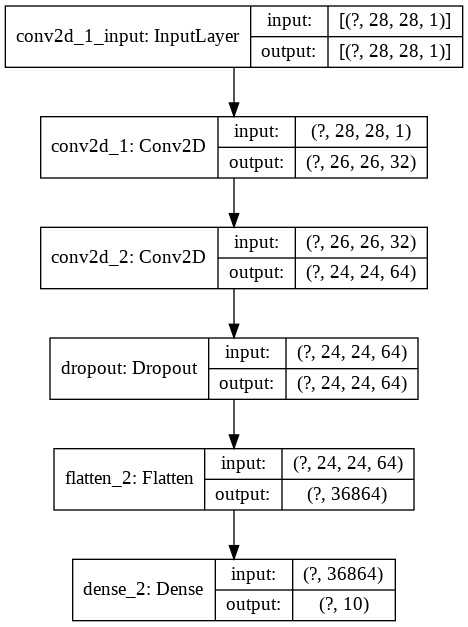

In [16]:
mnist_conv2_model = createModel(input_shape, num_filters=[32, 64], num_classes=num_classes)
modelName="mnist_conv2"

acc, plotFile = trainModel(mnist_conv2_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 

# Model: 2 Convolutional Layers (8, 16 filters)

Adding Conv block with 16 filters
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 43us/sample - loss: 1.0250 - acc: 0.8230 - val_loss: 0.3954 - val_acc: 0.8648
Epoch 2/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.3488 - acc: 0.8792 - val_loss: 0.3748 - val_acc: 0.8729
Epoch 3/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.3138 - acc: 0.8906 - val_loss: 0.3961 - val_acc: 0.8687
Epoch 4/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.2975 - acc: 0.8971 - val_loss: 0.3653 - val_acc: 0.8796
Epoch 5/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.2881 - acc: 0.9005 - val_loss: 0.3665 - val_acc: 0.8798
Epoch 6/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.2796 - acc: 0.9022 - val_loss: 0.3674 - val_acc: 0.8797
Test loss: 0.3653113018929958
Test accuracy: 0.8796


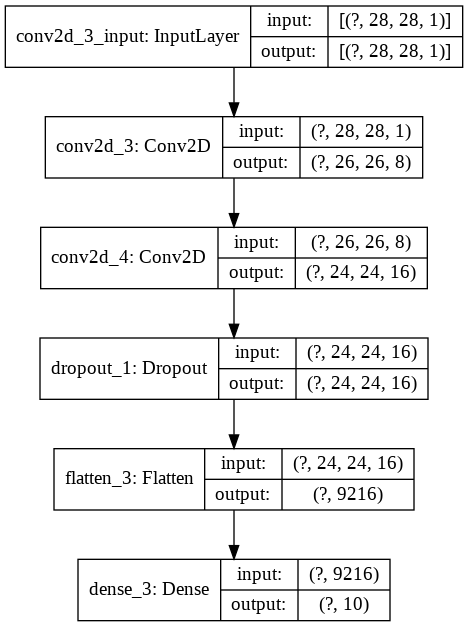

In [17]:
mnist_conv2_8_16_model = createModel(input_shape, num_filters=[8, 16], num_classes=num_classes)
modelName="mnist_conv2_8_16"

acc, plotFile = trainModel(mnist_conv2_8_16_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 38us/sample - loss: 1.5114 - acc: 0.7893 - val_loss: 0.4268 - val_acc: 0.8497
Epoch 2/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.3980 - acc: 0.8612 - val_loss: 0.3837 - val_acc: 0.8692
Epoch 3/20
60000/60000 [==============================] - 2s 33us/sample - loss: 0.3612 - acc: 0.8746 - val_loss: 0.3993 - val_acc: 0.8727
Epoch 4/20
60000/60000 [==============================] - 2s 34us/sample - loss: 0.3439 - acc: 0.8800 - val_loss: 0.3950 - val_acc: 0.8735
Test loss: 0.383677398109436
Test accuracy: 0.8692


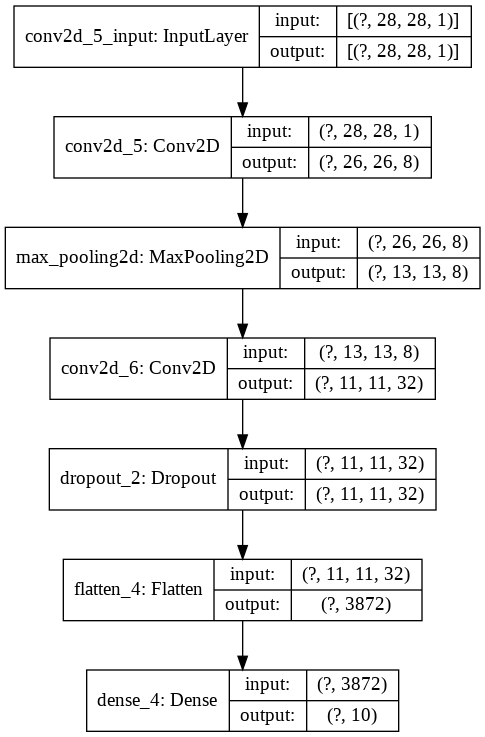

In [18]:
def createModelSeq():
  model = Sequential( [ 
                       Conv2D(8, kernel_size=(3, 3),
                              activation='relu',
                              input_shape=input_shape),
                       MaxPooling2D(pool_size=(2, 2)),
                       Conv2D(32, (3, 3), activation='relu'),
                       #MaxPooling2D(pool_size=(2, 2)),
                       #Conv2D(128, (3, 3), activation='relu'),
                       Dropout(0.25),
                       Flatten(),
                       #Dense(128, activation='relu'),
                       #Dropout(0.5),
                       Dense(num_classes, activation='softmax')
  ]
)

  return model

modelName="mnist_conv_seq"

mnist_seq_model = createModelSeq()
acc, plotFile = trainModel(mnist_seq_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 

In [19]:
model_vis = mnist_seq_model
model_vis = mnist_conv2_model
layer_dict = dict([(layer.name, layer) for layer in model_vis.layers[0:]])
layer_dict.keys()

dict_keys(['conv2d_1', 'conv2d_2', 'dropout', 'flatten_2', 'dense_2'])


# CNN Filter Visualization

Derived from Keras examples https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py

In [0]:
"""
#Visualization of the filters of VGG16, via gradient ascent in input space.

This script can run on CPU in a few minutes.

Results example: ![Visualization](http://i.imgur.com/4nj4KjN.jpg)
"""
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K

import pdb


In [0]:
def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(x))) + tf.keras.backend.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + tf.keras.backend.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if tf.keras.backend.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if tf.keras.backend.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if tf.keras.backend.image_data_format() == 'channels_first':
            loss = tf.keras.backend.mean(layer_output[:, filter_index, :, :])
        else:
            loss = tf.keras.backend.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = tf.keras.backend.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = tf.keras.backend.function([input_img], [loss, grads])

        
        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if tf.keras.backend.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, kjp_channels, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], kjp_channels))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        stitch = False
        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= tf.keras.backend.epsilon():
                    return None


        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]     

    # kjp added
    kjp_channels = 1 # 3
    
    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

    return processed_filters




In [0]:
tf.keras.backend.set_learning_phase(0)

import matplotlib as mpl
import math

def plotFilters(pfilters):
  fig = plt.figure(figsize=(max( math.ceil(len(pfilters)/6) * 3, 12),15))

  # Sort the filters
  pfilters.sort(key=lambda x: x[1], reverse=True)


  i = 0
  for filter, loss in pfilters:
    ax = fig.add_subplot( math.ceil(len(pfilters)/6), 6, i+1)
    
    ax.imshow(filter.reshape(28,28), cmap=mpl.cm.binary)
    i += 1

  return fig


def vis_conv_model(model_vis):
  conv_layers = [ layer.name  for layer in model_vis.layers if isinstance(layer, layers.Conv2D) ]

  pfilters = {}
  for conv_layer in conv_layers:
    print("Computing filters for ", conv_layer)
    pfilters[conv_layer] = visualize_layer(model_vis, conv_layer, output_dim=(28,28), upscaling_steps=1, upscaling_factor=1.)

  for conv_layer in conv_layers:
    print("Plotting filters for ", conv_layer)
    fig = plotFilters( pfilters[conv_layer] )
    fig.suptitle(conv_layer, size=16)

Computing filters for  conv2d_3
Compute filters 0 to 8
Costs of filter   0:    13 ( 0.16s )
Costs of filter   4:    15 ( 0.12s )
Costs of filter   6:    46 ( 0.12s )
3 filter processed.
Computing filters for  conv2d_4
Compute filters 0 to 16
0 filter processed.
Plotting filters for  conv2d_3
Plotting filters for  conv2d_4


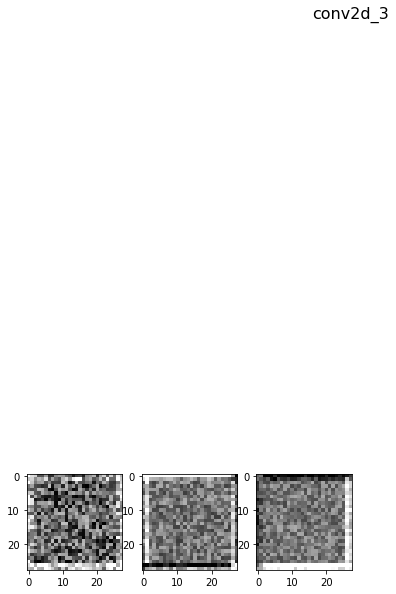

<Figure size 864x1080 with 0 Axes>

In [23]:
assert tf_major < 2

if tf_major <2:
  vis_conv_model(mnist_conv2_8_16_model)
else:
  print("Still have to convert to Tensorflow version 2, we are at version ", tf_major)